In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import glob
import numpy as np

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import glob


def load_data(metric_type="energy"):
    """
    Load data from CSV files for either energy or request metrics.

    Parameters:
        metric_type (str): Either "energy_history" or "request_stats"
    """
    dict_df = defaultdict(list)

    # Determine file pattern based on metric type
    pattern = f"../output/{metric_type}_*.csv"
    print(f"Looking for files matching pattern: {pattern}")

    files = glob.glob(pattern)
    if not files:
        print(f"No files found matching pattern: {pattern}")
        return dict_df

    print(f"Found {len(files)} files:")
    for file in files:
        print(f"Processing file: {file}")
        try:
            # Extract strategies from file name
            # Example filename: energy_history_AllOnStrategy_TimeGreedy_56.csv
            # or: request_stats_AllOnStrategy_TimeGreedy_56.csv
            parts = file.split("_")
            if len(parts) < 5:
                print(f"Skipping file {file} - unexpected filename format")
                continue

            power_strategy = parts[2]
            assignment_strategy = parts[3]
            user_count = int(parts[4].replace(".csv", ""))

            # Create a combined strategy key
            strategy_key = f"{power_strategy} + {assignment_strategy}"

            # Read the file into a DataFrame
            df = pd.read_csv(file)
            print(f"Loaded {file} with shape {df.shape}")

            # Store the data grouped by combined strategies
            dict_df[strategy_key].append(
                {
                    "user_count": user_count,
                    "power_strategy": power_strategy,
                    "assignment_strategy": assignment_strategy,
                    "data": df,
                }
            )

        except Exception as e:
            print(f"Error processing file {file}: {str(e)}")

    print(f"Loaded data for {len(dict_df)} strategy combinations")
    return dict_df


def plot_metrics(
    energy_dict, request_dict, power_strategy=None, assignment_strategy=None
):
    """
    Create a subplot with energy consumption and success rate metrics.

    Parameters:
        energy_dict (dict): Dictionary containing energy data
        request_dict (dict): Dictionary containing request data
        power_strategy (list or str): Power strategy/strategies to analyze
        assignment_strategy (list or str): Assignment strategy/strategies to analyze
    """
    # Ensure strategies are lists
    if isinstance(power_strategy, str):
        power_strategy = [power_strategy]
    if isinstance(assignment_strategy, str):
        assignment_strategy = [assignment_strategy]

    # Filter data by strategies
    def filter_data(data_dict):
        return {
            strategy_key: data
            for strategy_key, data in data_dict.items()
            if (not power_strategy or any(ps in strategy_key for ps in power_strategy))
            and (
                not assignment_strategy
                or any(as_ in strategy_key for as_ in assignment_strategy)
            )
        }

    filtered_energy = filter_data(energy_dict)
    filtered_request = filter_data(request_dict)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Define line styles
    line_styles = [
        ("solid", "o"),
        ("dashed", "s"),
        ("dashdot", "^"),
        ("dotted", "D"),
        ("-", "v"),
        ("--", "p"),
    ]

    # Plot energy data
    for idx, (strategy_key, data) in enumerate(filtered_energy.items()):
        user_counts = []
        energies = []

        for entry in data:
            total_energy = entry["data"].sum().sum()
            user_counts.append(entry["user_count"])
            energies.append(total_energy)

        # Sort the data
        sorted_data = sorted(zip(user_counts, energies))
        user_counts, energy_values = zip(*sorted_data)

        line_style, marker = line_styles[idx % len(line_styles)]
        ax1.plot(
            user_counts,
            energy_values,
            linestyle=line_style,
            marker=marker,
            markersize=8,
            label=strategy_key,
        )

    ax1.set_title("Energy Consumption vs Number of Users")
    ax1.set_xlabel("Number of Users")
    ax1.set_ylabel("Total Energy (J)")
    ax1.grid(True)
    ax1.legend(title="Strategies", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Plot success rate data
    for idx, (strategy_key, data) in enumerate(filtered_request.items()):
        user_counts = []
        success_rates = []

        for entry in data:
            request_stats = entry["data"]
            completed_requests = request_stats[
                request_stats["status"] == "RequestStatus.COMPLETED"
            ].shape[0]
            failed_requests = request_stats[
                request_stats["status"] == "RequestStatus.FAILED"
            ].shape[0]

            total_requests = completed_requests + failed_requests
            success_rate = (
                (completed_requests / total_requests * 100) if total_requests > 0 else 0
            )

            user_counts.append(entry["user_count"])
            success_rates.append(success_rate)

        # Sort the data
        sorted_data = sorted(zip(user_counts, success_rates))
        user_counts, rates = zip(*sorted_data)

        line_style, marker = line_styles[idx % len(line_styles)]
        ax2.plot(
            user_counts,
            rates,
            linestyle=line_style,
            marker=marker,
            markersize=8,
            label=strategy_key,
        )

    ax2.set_title("Success Rate vs Number of Users")
    ax2.set_xlabel("Number of Users")
    ax2.set_ylabel("Success Rate (%)")
    ax2.grid(True)
    ax2.legend(title="Strategies", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


def print_combined_table(energy_dict, request_dict, user_count=None):
    """
    Print a combined table showing energy consumption, success rates, and energy efficiency.

    Parameters:
        energy_dict (dict): Dictionary containing energy data
        request_dict (dict): Dictionary containing request data
        user_count (int): Filter results for this user count. If None, use the smallest available.
    """
    # Find available user counts
    available_counts = set()
    for strategy_data in energy_dict.values():
        available_counts.update(run["user_count"] for run in strategy_data)

    if not available_counts:
        print("No data available")
        return None

    # If user_count not specified or invalid, use the smallest available
    if user_count is None or user_count not in available_counts:
        user_count = min(available_counts)
        print(f"Using user count: {user_count}")
        print(f"Available user counts: {sorted(available_counts)}")

    results = []

    # Collect data for each strategy pair
    strategy_keys = set(energy_dict.keys()) & set(request_dict.keys())

    for strategy_key in strategy_keys:
        # Find the runs with specified user count
        energy_run = next(
            (
                run
                for run in energy_dict[strategy_key]
                if run["user_count"] == user_count
            ),
            None,
        )
        request_run = next(
            (
                run
                for run in request_dict[strategy_key]
                if run["user_count"] == user_count
            ),
            None,
        )

        if energy_run and request_run:
            # Calculate energy metrics
            total_energy = energy_run["data"].sum().sum()

            # Calculate success rate metrics
            request_stats = request_run["data"]
            completed_requests = request_stats[
                request_stats["status"] == "RequestStatus.COMPLETED"
            ].shape[0]
            failed_requests = request_stats[
                request_stats["status"] == "RequestStatus.FAILED"
            ].shape[0]

            total_requests = completed_requests + failed_requests
            success_rate = (
                (completed_requests / total_requests * 100) if total_requests > 0 else 0
            )

            # Calculate energy efficiency (Energy/QoS ratio)
            # Adding a small epsilon to prevent division by zero
            epsilon = 1e-10
            percentage_success = success_rate / 100
            energy_efficiency = total_energy / (percentage_success**2 + epsilon)

            # Split strategy key into components
            power_strat, assign_strat = strategy_key.split(" + ")

            # Add to results
            results.append(
                {
                    "Power Strategy": power_strat,
                    "Assignment Strategy": assign_strat,
                    "Total Energy (J)": total_energy,
                    "Success Rate": success_rate,
                    "Energy/QoS Ratio": energy_efficiency,
                    "Completed Requests": completed_requests,
                    "Failed Requests": failed_requests,
                }
            )

    if not results:
        print(f"No data found for user count {user_count}")
        return None

    # Convert to DataFrame for nice display
    results_df = pd.DataFrame(results)

    # Sort by Energy/QoS ratio (ascending, as lower is better)
    results_df = results_df.sort_values("Energy/QoS Ratio", ascending=True)

    # Format the numeric columns
    results_df["Total Energy (J)"] = results_df["Total Energy (J)"].map(
        "{:,.2f}".format
    )
    results_df["Success Rate"] = results_df["Success Rate"].map("{:.2f}".format)
    results_df["Energy/QoS Ratio"] = results_df["Energy/QoS Ratio"].map("{:.2f}".format)

    # Rename columns for display
    results_df = results_df.rename(
        columns={
            "Success Rate": "Success Rate (%)",
            "Energy/QoS Ratio": "Energy/QoS (J/%)",
        }
    )

    print(f"\nCombined Metrics for {user_count} Users:")
    print("=" * 120)
    print(results_df.to_string(index=False))
    print("=" * 120)
    print("\nNote: Lower Energy/QoS ratio indicates better energy efficiency")

    return results_df


def plot_efficiency_metrics(
    energy_dict, request_dict, power_strategy=None, assignment_strategy=None
):
    """
    Create a plot showing Energy/QoS ratio vs number of users.
    """
    # Ensure strategies are lists
    if isinstance(power_strategy, str):
        power_strategy = [power_strategy]
    if isinstance(assignment_strategy, str):
        assignment_strategy = [assignment_strategy]

    # Filter data by strategies
    def filter_data(data_dict):
        return {
            strategy_key: data
            for strategy_key, data in data_dict.items()
            if (not power_strategy or any(ps in strategy_key for ps in power_strategy))
            and (
                not assignment_strategy
                or any(as_ in strategy_key for as_ in assignment_strategy)
            )
        }

    filtered_energy = filter_data(energy_dict)
    filtered_request = filter_data(request_dict)

    # Create plot
    plt.figure(figsize=(12, 6))

    # Define line styles
    line_styles = [
        ("solid", "o"),
        ("dashed", "s"),
        ("dashdot", "^"),
        ("dotted", "D"),
        ("-", "v"),
        ("--", "p"),
    ]
    max_efficiency_ratios = []

    # Plot efficiency data
    for idx, strategy_key in enumerate(filtered_energy.keys()):
        if strategy_key not in filtered_request:
            continue

        user_counts = []
        efficiency_ratios = []

        energy_data = filtered_energy[strategy_key]
        request_data = filtered_request[strategy_key]

        # Match energy and request data by user count
        user_counts_set = set(run["user_count"] for run in energy_data)
        user_counts_set &= set(run["user_count"] for run in request_data)

        for user_count in sorted(user_counts_set):
            energy_run = next(
                run for run in energy_data if run["user_count"] == user_count
            )
            request_run = next(
                run for run in request_data if run["user_count"] == user_count
            )

            # Calculate metrics
            total_energy = energy_run["data"].sum().sum()

            request_stats = request_run["data"]
            completed = request_stats[
                request_stats["status"] == "RequestStatus.COMPLETED"
            ].shape[0]
            total = (
                completed
                + request_stats[
                    request_stats["status"] == "RequestStatus.FAILED"
                ].shape[0]
            )

            success_rate = (completed / total) if total > 0 else 0
            efficiency_ratio = total_energy / (success_rate**2 + 1e-10)

            user_counts.append(user_count)
            efficiency_ratios.append(efficiency_ratio)

        line_style, marker = line_styles[idx % len(line_styles)]
        plt.plot(
            user_counts,
            efficiency_ratios,
            linestyle=line_style,
            marker=marker,
            markersize=8,
            label=strategy_key,
        )

        max_efficiency_ratios.append(max(efficiency_ratios))

    # Calculate the adjusted y-max
    overall_max = np.mean(max_efficiency_ratios)
    # if one strategy has a very high value, it will skew the plot, remove it from the calculation
    overall_max = np.mean([x for x in max_efficiency_ratios if x < 1.5 * overall_max])

    adjusted_ymax = overall_max * 1.5

    plt.title("Energy Efficiency vs Number of Users")
    plt.xlabel("Number of Users")
    plt.ylabel(r"Energy/QoS Ratio$^2$ (J/%$^2$)")
    plt.ylim(0, adjusted_ymax)
    plt.grid(True)
    plt.legend(title="Strategies", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


Loading energy history data...
Looking for files matching pattern: ../output/energy_history_*.csv
Found 56 files:
Processing file: ../output\energy_history_OnDemand_ClosestNodeAssignment_10.csv
Loaded ../output\energy_history_OnDemand_ClosestNodeAssignment_10.csv with shape (1001, 16)
Processing file: ../output\energy_history_OnDemand_ClosestNodeAssignment_100.csv
Loaded ../output\energy_history_OnDemand_ClosestNodeAssignment_100.csv with shape (1001, 106)
Processing file: ../output\energy_history_OnDemand_ClosestNodeAssignment_20.csv
Loaded ../output\energy_history_OnDemand_ClosestNodeAssignment_20.csv with shape (1001, 26)
Processing file: ../output\energy_history_OnDemand_ClosestNodeAssignment_30.csv
Loaded ../output\energy_history_OnDemand_ClosestNodeAssignment_30.csv with shape (1001, 36)
Processing file: ../output\energy_history_OnDemand_ClosestNodeAssignment_40.csv
Loaded ../output\energy_history_OnDemand_ClosestNodeAssignment_40.csv with shape (1001, 46)
Processing file: ../ou

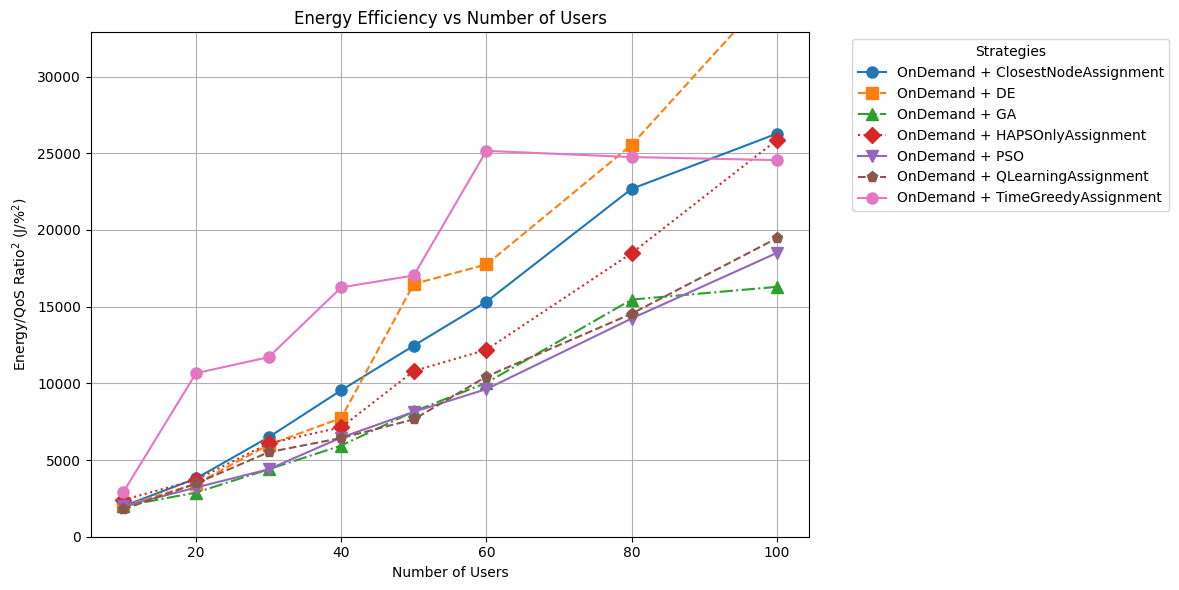


Combined Metrics for 10 Users:
Power Strategy   Assignment Strategy Total Energy (J) Success Rate (%) Energy/QoS (J/%)  Completed Requests  Failed Requests
      OnDemand   QLearningAssignment         1,786.84           100.00          1786.84                  10                0
      OnDemand ClosestNodeAssignment         1,614.11            90.00          1992.73                   9                1
      OnDemand                    GA         1,614.11            90.00          1992.73                   9                1
      OnDemand                   PSO         1,614.11            90.00          1992.73                   9                1
      OnDemand                    DE         1,614.21            90.00          1992.85                   9                1
      OnDemand    HAPSOnlyAssignment         1,536.00            80.00          2400.00                   8                2
      OnDemand  TimeGreedyAssignment         2,364.66            90.00          2919.33      

In [57]:
# Example usage:
# Load both energy and request data
print("\nLoading energy history data...")
energy_dict = load_data("energy_history")

print("\nLoading request stats data...")
request_dict = load_data("request_stats")

if not energy_dict or not request_dict:
    print("Error: No data loaded. Please check if the data files exist in ../output/")
    exit(1)

# Plot efficiency metrics
plot_efficiency_metrics(
    energy_dict,
    request_dict,
    assignment_strategy=[
        "TimeGreedy",
        "ClosestNode",
        "HAPSOnly",
        "GA",
        "PSO",
        "DE",
        "QLearning",
    ],
    power_strategy=["OnDemand"],
)

# Print combined table for each available user count
for user_count in [10, 20, 30, 40]:
    combined_table = print_combined_table(
        energy_dict, request_dict, user_count=user_count
    )